In [1]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# KDD Cup 98 LTV Prediction

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime_value/blob/master/notebooks/kdd_cup_98/regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [2]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
# !pip install -q git+https://github.com/google/lifetime_value
import lifetime_value as ltv

2024-11-27 04:20:57.743808: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 04:20:57.758227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732681257.776118   28126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732681257.781339   28126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 04:20:57.799010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

## Configs

In [4]:
MODEL = 'dnn'
# LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LOSS = 'mse' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
DATA_FOLDER = './tmp/kdd_cup_98/' # @param { isTemplate: true, type: 'string'}
OUTPUT_CSV_FOLDER = f'{DATA_FOLDER}result' # @param { isTemplate: true, type: 'string'}

## Load data

Download kdd_cup_98 data to /tmp/lifetime-value/kdd_cup_98

In [5]:
# Set it DATA_FOLDER as an environment variable
%env DATA_FOLDER=$DATA_FOLDER

env: DATA_FOLDER=./tmp/kdd_cup_98/


In [6]:
%%bash
mkdir -p $DATA_FOLDER
wget -N https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip -P $DATA_FOLDER
wget -N https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip -P $DATA_FOLDER
wget -N https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/valtargt.txt -P $DATA_FOLDER
cd $DATA_FOLDER
unzip -n cup98lrn.zip
unzip -n cup98val.zip

--2024-11-27 04:20:59--  https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98lrn.zip
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./tmp/kdd_cup_98/cup98lrn.zip’ not modified on server. Omitting download.

--2024-11-27 04:21:00--  https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/cup98val.zip
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./tmp/kdd_cup_98/cup98val.zip’ not modified on server. Omitting download.

--2024-11-27 04:21:00--  https://kdd.ics.uci.edu/databases/kddcup98/epsilon_mirror/valtargt.txt
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:443... connected.
HTTP request sen

Archive:  cup98lrn.zip
Archive:  cup98val.zip


In [7]:
df_train = pd.read_csv(f'{DATA_FOLDER}cup98LRN.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv(f'{DATA_FOLDER}cup98VAL.txt')
df_eval_target = pd.read_csv(f'{DATA_FOLDER}valtargt.txt')
df_eval = df_eval.merge(df_eval_target, on='CONTROLN')

/tmp/ipykernel_28126/890100394.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f'{DATA_FOLDER}cup98LRN.txt')
/tmp/ipykernel_28126/890100394.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eval = pd.read_csv(f'{DATA_FOLDER}cup98VAL.txt')


In [8]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

## Label distribution

In [9]:
y = df['TARGET_D'][:num_train]

In [10]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1. 
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()
  output_file = tf.io.gfile.GFile(
          f'{DATA_FOLDER}histogram_kdd98_log_scale.pdf',
          'wb')
  fig.savefig(output_file, bbox_inches='tight', format='pdf')

/tmp/ipykernel_28126/3761247075.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


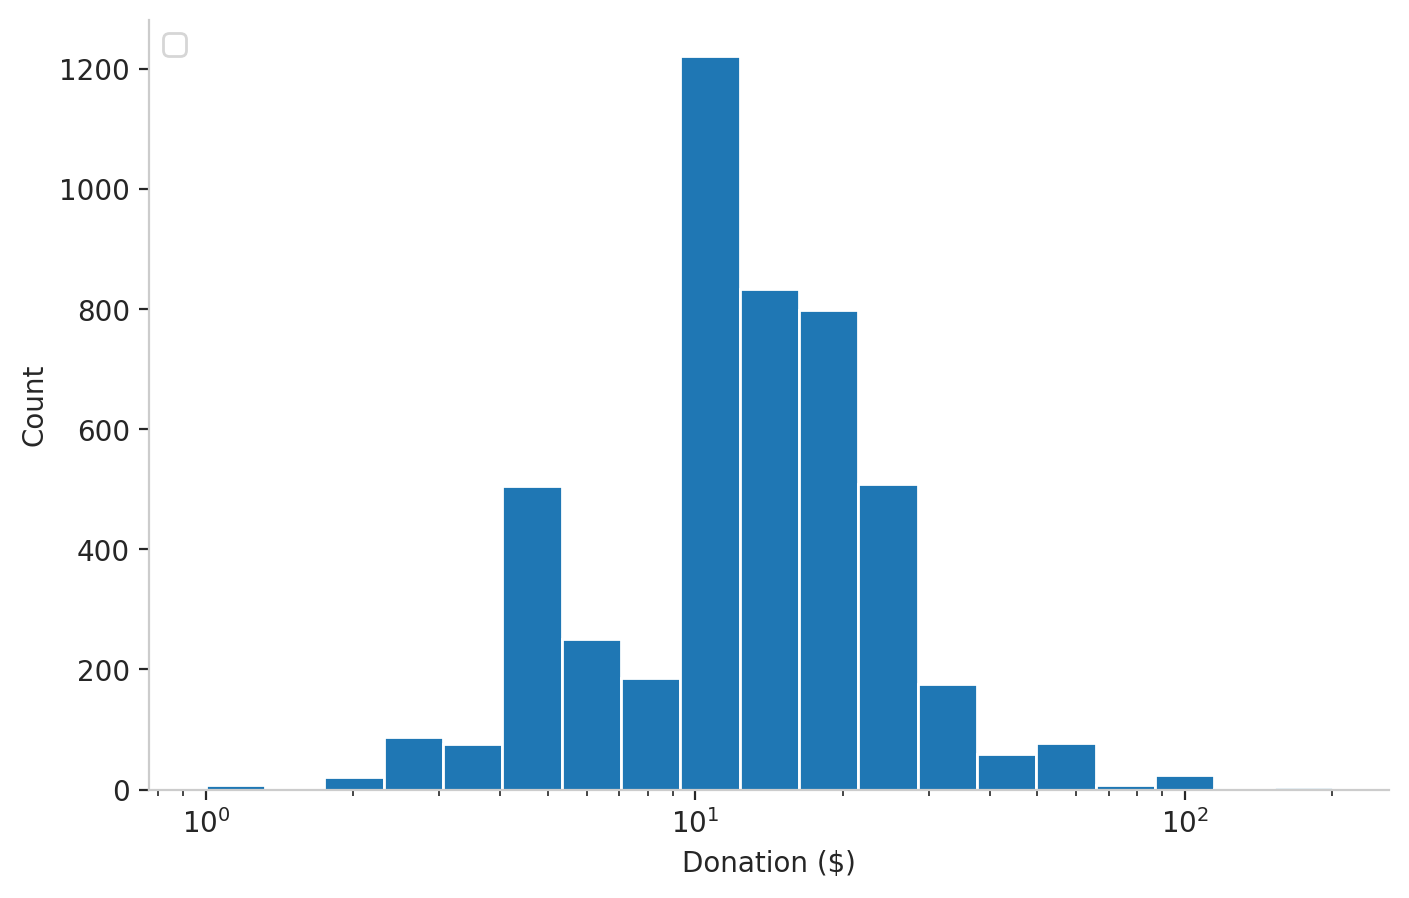

In [11]:
plot_hist_log_scale(y[y>0])

## Preprocess features

### Vocab

In [12]:
VOCAB_FEATURES = [
    'ODATEDW',  # date of donor's first gift (YYMM)
    'OSOURCE',  # donor acquisition mailing list
    'TCODE',    # donor title code
    'STATE',
    'ZIP',
    'DOMAIN',   # urbanicity level and socio-economic status of the neighborhood
    'CLUSTER',  # socio-economic status
    'GENDER',
    'MAXADATE', # date of the most recent promotion received
    'MINRDATE',
    'LASTDATE',
    'FISTDATE',
    'RFA_2A',
]

In [13]:
df['ODATEDW'] = df['ODATEDW'].astype('str')
df['TCODE'] = df['TCODE'].apply(
    lambda x: '{:03d}'.format(x // 1000 if x > 1000 else x))
df['ZIP'] = df['ZIP'].str.slice(0, 5)
df['MAXADATE'] = df['MAXADATE'].astype('str')
df['MINRDATE'] = df['MINRDATE'].astype('str')
df['LASTDATE'] = df['LASTDATE'].astype('str')
df['FISTDATE'] = df['FISTDATE'].astype('str')

In [14]:
def label_encoding(y, frequency_threshold=100):
  #value_counts = pd.value_counts(y) # raises FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  value_counts = pd.Series(y).value_counts()
  categories = value_counts[
      value_counts >= frequency_threshold].index.to_numpy()
  # 0 indicates the unknown category.
  return pd.Categorical(y, categories=categories).codes + 1

In [15]:
for key in VOCAB_FEATURES:
  df[key] = label_encoding(df[key])

### Indicator

In [16]:
MAIL_ORDER_RESPONSES = [
    'MBCRAFT',
    'MBGARDEN',
    'MBBOOKS',
    'MBCOLECT',
    'MAGFAML',
    'MAGFEM',
    'MAGMALE',
    'PUBGARDN',
    'PUBCULIN',
    'PUBHLTH',
    'PUBDOITY',
    'PUBNEWFN',
    'PUBPHOTO',
    'PUBOPP',
    'RFA_2F',
]

In [17]:
INDICATOR_FEATURES = [
    'AGE',  # age decile, 0 indicates unknown
    'NUMCHLD',
    'INCOME',
    'WEALTH1',
    'HIT',
] + MAIL_ORDER_RESPONSES

In [18]:
df['AGE'] = pd.qcut(df['AGE'].values, 10).codes + 1
df['NUMCHLD'] = df['NUMCHLD'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['INCOME'] = df['INCOME'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['WEALTH1'] = df['WEALTH1'].apply(lambda x: 0 if np.isnan(x) else int(x) + 1)
df['HIT'] = pd.qcut(df['HIT'].values, q=50, duplicates='drop').codes

for col in MAIL_ORDER_RESPONSES:
  df[col] = pd.qcut(df[col].values, q=20, duplicates='drop').codes + 1

### Numeric

In [19]:
NUMERIC_FEATURES = [
    # binary
    'MAILCODE',  # bad address
    'NOEXCH',    # do not exchange
    'RECINHSE',  # donor has given to PVA's in house program
    'RECP3',     # donor has given to PVA's P3 program
    'RECPGVG',   # planned giving record
    'RECSWEEP',  # sweepstakes record
    'HOMEOWNR',  # home owner
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',

    # continuous
    'CARDPROM',
    'NUMPROM',
    'CARDPM12',
    'NUMPRM12',
    'RAMNTALL',
    'NGIFTALL',
    'MINRAMNT',
    'MAXRAMNT',
    'LASTGIFT',
    'AVGGIFT',
]

In [20]:
df['MAILCODE'] = (df['MAILCODE'] == 'B').astype('float32')
df['PVASTATE'] = df['PVASTATE'].isin(['P', 'E']).astype('float32')
df['NOEXCH'] = df['NOEXCH'].isin(['X', '1']).astype('float32')
df['RECINHSE'] = (df['RECINHSE'] == 'X').astype('float32')
df['RECP3'] = (df['RECP3'] == 'X').astype('float32')
df['RECPGVG'] = (df['RECPGVG'] == 'X').astype('float32')
df['RECSWEEP'] = (df['RECSWEEP'] == 'X').astype('float32')
df['HOMEOWNR'] = (df['HOMEOWNR'] == 'H').astype('float32')
df['CHILD03'] = df['CHILD03'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD07'] = df['CHILD07'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD12'] = df['CHILD12'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD18'] = df['CHILD18'].isin(['M', 'F', 'B']).astype('float32')

df['CARDPROM'] = df['CARDPROM'] / 100
df['NUMPROM'] = df['NUMPROM'] / 100
df['CARDPM12'] = df['CARDPM12'] / 100
df['NUMPRM12'] = df['NUMPRM12'] / 100
df['RAMNTALL'] = np.log1p(df['RAMNTALL'])
df['NGIFTALL'] = np.log1p(df['NGIFTALL'])
df['MINRAMNT'] = np.log1p(df['MINRAMNT'])
df['MAXRAMNT'] = np.log1p(df['MAXRAMNT'])
df['LASTGIFT'] = np.log1p(df['LASTGIFT'])
df['AVGGIFT'] = np.log1p(df['AVGGIFT'])

### All

In [21]:
CATEGORICAL_FEATURES = VOCAB_FEATURES + INDICATOR_FEATURES
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Train/eval split

In [22]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = dict()
      
    for k, v in dict(df[CATEGORICAL_FEATURES]).items():
        features[k] = v.values    

    features['numeric'] = df[NUMERIC_FEATURES].astype('float32').values  

    return features

  x_train, y_train = feature_dict(df_train), df_train['TARGET_D'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['TARGET_D'].astype(
      'float32').values

  return x_train, x_eval, y_train, y_eval

## Model

In [23]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size)),
      tf.keras.layers.Flatten(),
  ])

# NOTE: The call to the fit method fails if the numeric, multi-dimensional, feature is not the last parameter
def dnn_model(output_units):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')
  numeric_inputs = [numeric_input]    

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].max() + 1)(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate(embedding_outputs + numeric_inputs)
    
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(units=output_units),
  ])
  return tf.keras.Model(
      inputs=embedding_inputs + numeric_inputs, outputs=deep_model(deep_input))

## Loss

In [24]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [25]:
x_train, x_eval, y_train, y_eval = dnn_split(df)

In [26]:
model = dnn_model(output_units)

I0000 00:00:1732681270.092404   28126 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21801 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [27]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=LEARNING_RATE), loss=loss)

## Train

In [28]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [29]:
%%time
# y array needs to have a two dimensional shape to work with ziln loss function
# so we use [:, np.newaxis] to make the data two-dimensional for the fit function call
history = model.fit(
    x=x_train,
    y=y_train[:, np.newaxis],
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval[:, np.newaxis])).history

Epoch 1/200


/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP', 'DOMAIN', 'CLUSTER', 'GENDER', 'MAXADATE', 'MINRDATE', 'LASTDATE', 'FISTDATE', 'RFA_2A', 'AGE', 'NUMCHLD', 'INCOME', 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'RFA_2F', 'numeric']. Received: the structure of inputs={'ODATEDW': '*', 'OSOURCE': '*', 'TCODE': '*', 'STATE': '*', 'ZIP': '*', 'DOMAIN': '*', 'CLUSTER': '*', 'GENDER': '*', 'MAXADATE': '*', 'MINRDATE': '*', 'LASTDATE': '*', 'FISTDATE': '*', 'RFA_2A': '*', 'AGE': '*', 'NUMCHLD': '*', 'INCOME': '*', 'WEALTH1': '*', 'HIT': '*', 'MBCRAFT': '*', 'MBGARDEN': '*', 'MBBOOKS': '*', 'MBCOLECT': '*', 'MAGFAML': '*', 'MAGFEM': '*', 'MAGMALE': '*', 'PUBGARDN': '*', 'PUBCULIN': '*', 'P

47/47 - 25s - 534ms/step - loss: 19.5878 - val_loss: 22.2897 - learning_rate: 1.0000e-03
Epoch 2/200
47/47 - 0s - 8ms/step - loss: 19.5544 - val_loss: 22.2736 - learning_rate: 1.0000e-03
Epoch 3/200
47/47 - 0s - 8ms/step - loss: 19.5196 - val_loss: 22.2331 - learning_rate: 1.0000e-03
Epoch 4/200
47/47 - 0s - 8ms/step - loss: 19.4912 - val_loss: 22.2507 - learning_rate: 1.0000e-03
Epoch 5/200
47/47 - 0s - 7ms/step - loss: 19.4738 - val_loss: 22.2355 - learning_rate: 1.0000e-03
Epoch 6/200
47/47 - 0s - 8ms/step - loss: 19.4578 - val_loss: 22.2513 - learning_rate: 1.0000e-03
Epoch 7/200
47/47 - 0s - 8ms/step - loss: 19.4381 - val_loss: 22.2254 - learning_rate: 1.0000e-03
Epoch 8/200
47/47 - 0s - 8ms/step - loss: 19.4059 - val_loss: 22.1992 - learning_rate: 1.0000e-03
Epoch 9/200
47/47 - 0s - 8ms/step - loss: 19.3794 - val_loss: 22.1653 - learning_rate: 1.0000e-03
Epoch 10/200
47/47 - 0s - 8ms/step - loss: 19.3080 - val_loss: 22.1501 - learning_rate: 1.0000e-03
Epoch 11/200
47/47 - 0s - 8m

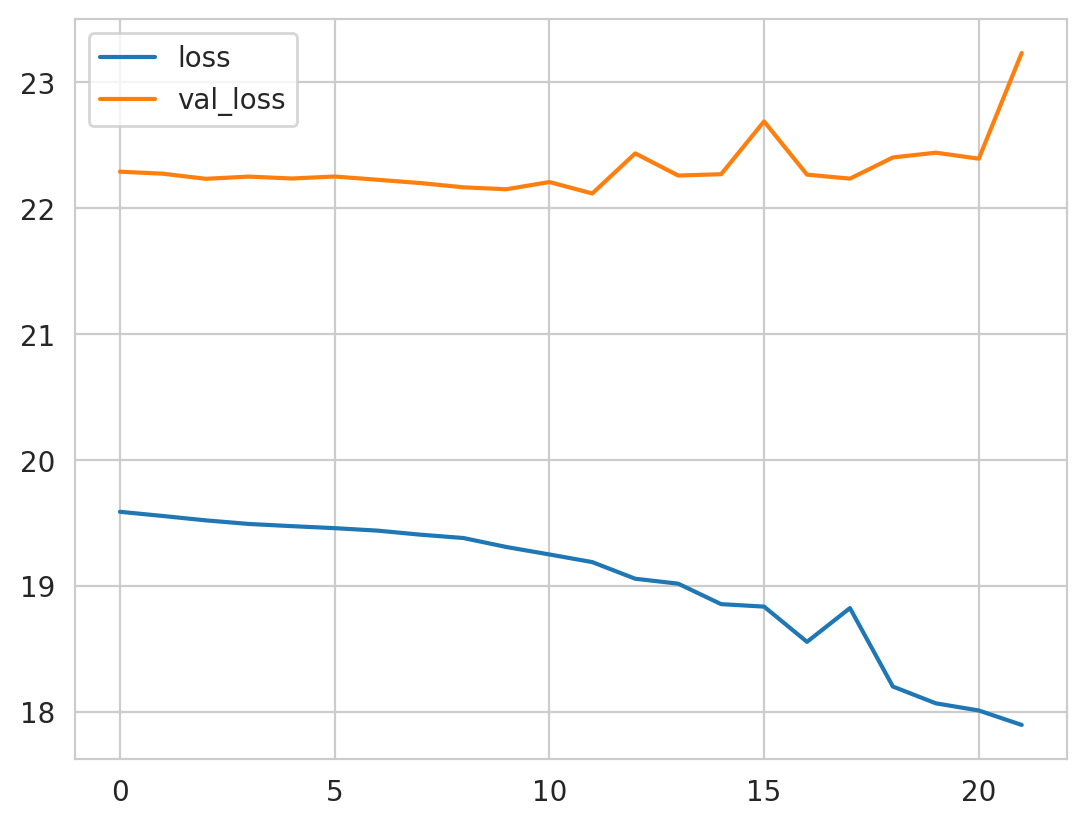

In [30]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

## Eval

In [31]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ODATEDW', 'OSOURCE', 'TCODE', 'STATE', 'ZIP', 'DOMAIN', 'CLUSTER', 'GENDER', 'MAXADATE', 'MINRDATE', 'LASTDATE', 'FISTDATE', 'RFA_2A', 'AGE', 'NUMCHLD', 'INCOME', 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'RFA_2F', 'numeric']. Received: the structure of inputs={'ODATEDW': '*', 'OSOURCE': '*', 'TCODE': '*', 'STATE': '*', 'ZIP': '*', 'DOMAIN': '*', 'CLUSTER': '*', 'GENDER': '*', 'MAXADATE': '*', 'MINRDATE': '*', 'LASTDATE': '*', 'FISTDATE': '*', 'RFA_2A': '*', 'AGE': '*', 'NUMCHLD': '*', 'INCOME': '*', 'WEALTH1': '*', 'HIT': '*', 'MBCRAFT': '*', 'MBGARDEN': '*', 'MBBOOKS': '*', 'MBCOLECT': '*', 'MAGFAML': '*', 'MAGFEM': '*', 'MAGMALE': '*', 'PUBGARDN': '*', 'PUBCULIN': '*', 'P

95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step


### Total Profit

In [32]:
unit_costs = [0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.9, 1.0]

In [33]:
num_mailed = [np.sum(y_pred > v) for v in unit_costs]
num_mailed

[np.int64(88109),
 np.int64(70380),
 np.int64(51959),
 np.int64(38647),
 np.int64(35661),
 np.int64(24210),
 np.int64(16746),
 np.int64(11680)]

In [34]:
baseline_total_profit = np.sum(y_eval - 0.68)
baseline_total_profit

np.float32(10560.074)

In [35]:
total_profits = [np.sum(y_eval[y_pred > v] - v) for v in unit_costs]
total_profits

[np.float32(37421.535),
 np.float32(27591.77),
 np.float32(18713.871),
 np.float32(13134.807),
 np.float32(12032.072),
 np.float32(7122.269),
 np.float32(4546.551),
 np.float32(3503.5)]

### Gini Coefficient

In [36]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, x_eval['numeric'][:, 19]),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [37]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

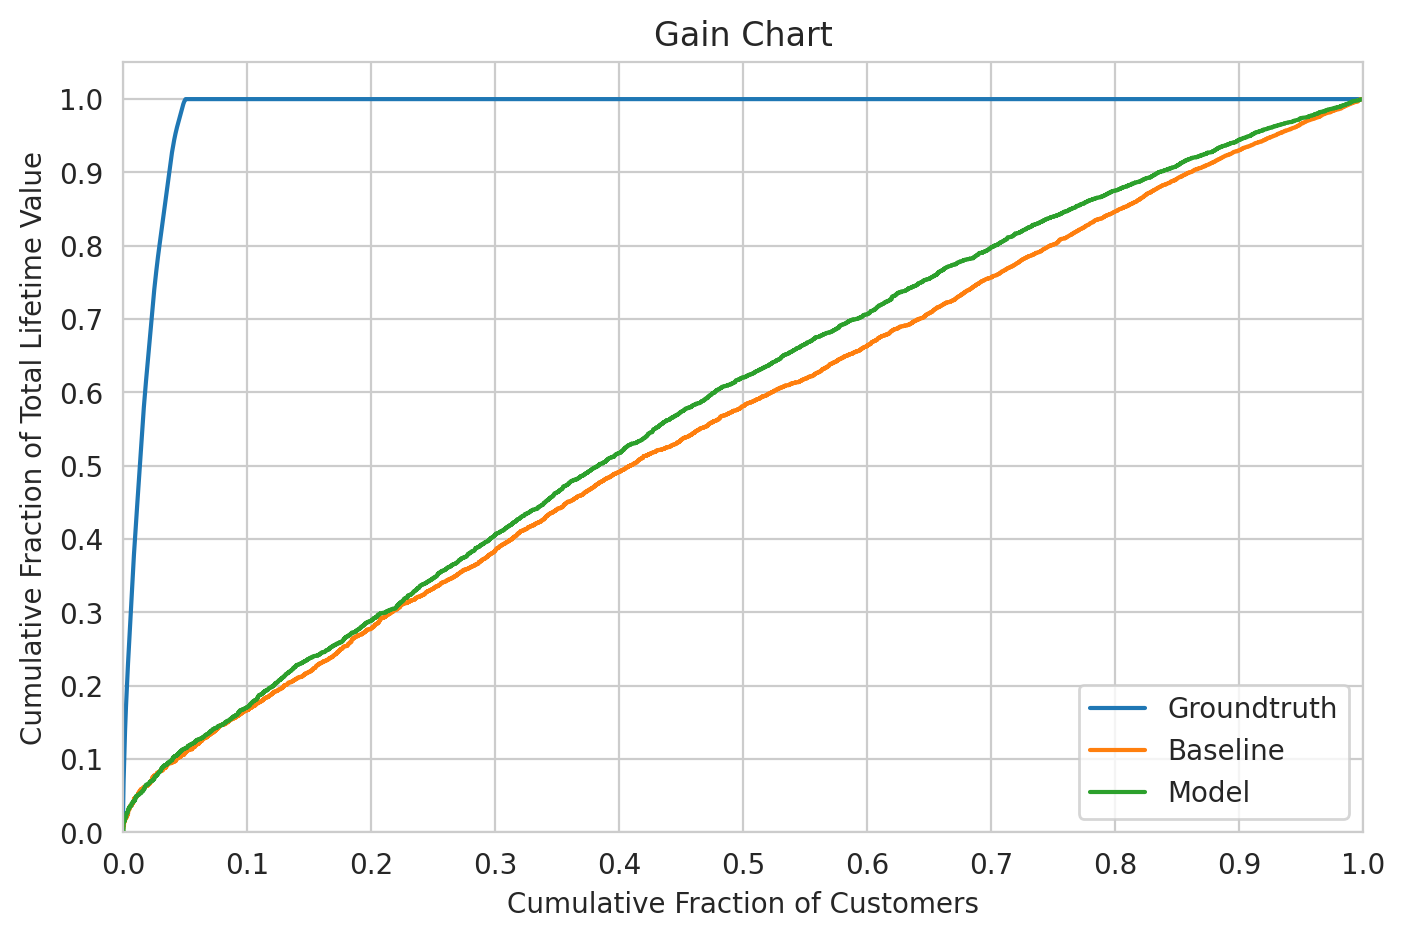

In [38]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='lower right')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart');

In [39]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  normalized = raw / raw[0]


,raw,normalized
lorenz,0.967057,1.000000
baseline,0.124679,0.128926
model,0.172370,0.178241


### Calibration

In [40]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

/home/reza/miniconda3/envs/clv-google/lib/python3.12/site-packages/lifetime_value/metrics.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('decile').apply(_aggregate_fn)


,label_mean,pred_mean,normalized_rmse,normalized_mae,decile_mape
decile,,,,,
0,0.437947,0.352641,5.766818,1.730310,0.194787
1,0.547266,0.439714,5.437359,1.730648,0.196526
2,0.613052,0.490836,5.201873,1.725338,0.199357
3,0.720037,0.540963,5.801156,1.672225,0.248701
4,0.679724,0.593936,5.146513,1.786980,0.126210
5,0.814705,0.650354,4.845120,1.712039,0.201731
6,0.883107,0.715208,4.884840,1.720317,0.190123
7,0.918983,0.803293,5.124897,1.780690,0.125889
8,0.932962,0.945861,4.744325,1.905122,0.013827


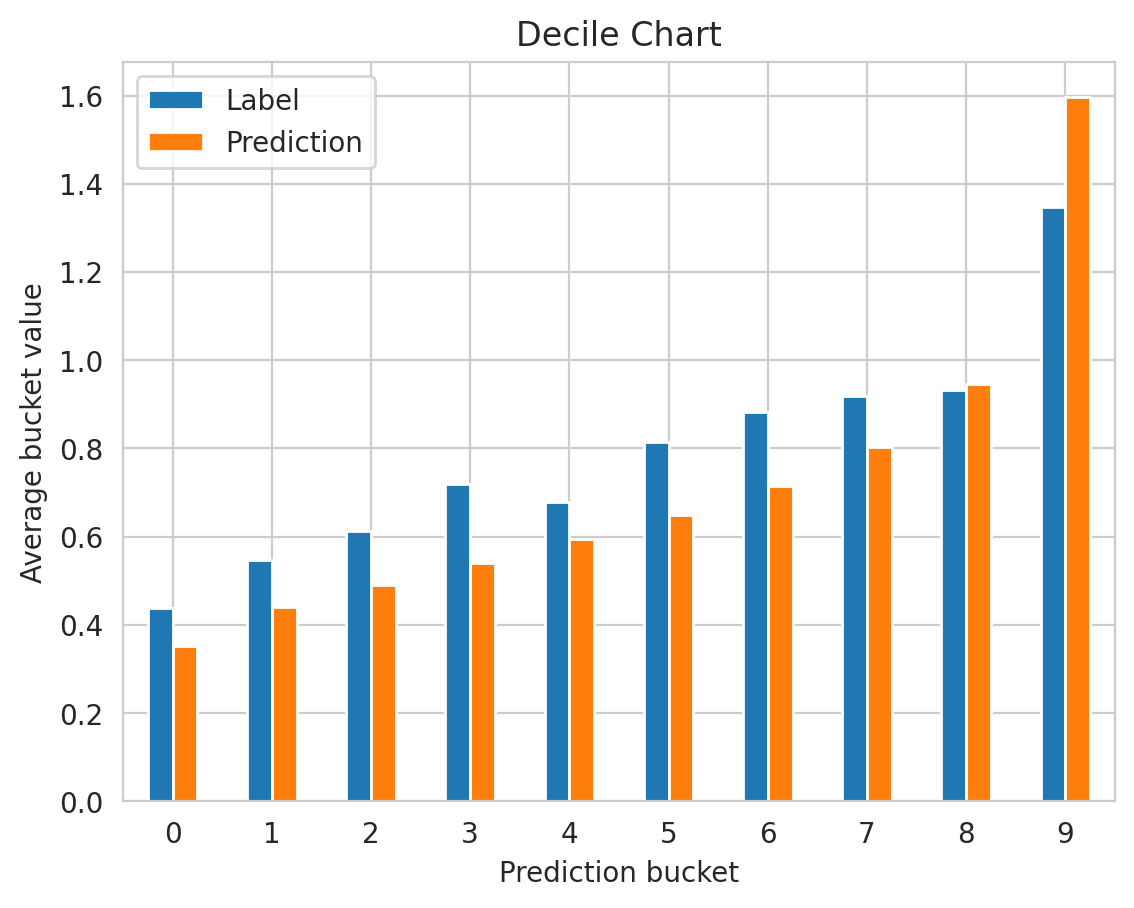

In [41]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left');

### Rank Correlation

In [42]:
def spearmanr(
    x1: Sequence[float],
    x2: Sequence[float]) -> float:
  """Calculates spearmanr rank correlation coefficient.

  See https://docs.scipy.org/doc/scipy/reference/stats.html.

  Args:
    x1: 1D array_like.
    x2: 1D array_like.

  Returns:
    correlation: float.
  """
  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

np.float64(0.011971924410671818)

### All metrics together

In [43]:
df_metrics = pd.DataFrame({
    'model': MODEL,
    'loss_function': LOSS,
    'train_loss': history['loss'][-1],
    'eval_loss': history['val_loss'][-1],
    'label_positive': np.mean(y_eval > 0),
    'label_mean': y_eval.mean(),
    'pred_mean': y_pred.mean(),
    'decile_mape': df_decile['decile_mape'].mean(),
    'baseline_gini': gini['normalized'][1],
    'gini': gini['normalized'][2],
    'spearman_corr': spearman_corr,
}, index=[VERSION])

/tmp/ipykernel_28126/3720388555.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'baseline_gini': gini['normalized'][1],
/tmp/ipykernel_28126/3720388555.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'gini': gini['normalized'][2],


In [44]:
for unit_cost, total_profit in zip(unit_costs, total_profits):
  df_metrics['total_profit_{:02d}'.format(int(unit_cost * 100))] = total_profit

In [45]:
df_metrics.T

,0
model,dnn
loss_function,mse
train_loss,17.894335
eval_loss,23.232906
label_positive,0.050567
label_mean,0.789582
pred_mean,0.712849
decile_mape,0.168085
baseline_gini,0.128926
gini,0.178241


## Save

In [46]:
output_path = OUTPUT_CSV_FOLDER

In [47]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [48]:
output_file = os.path.join(output_path, '{}_regression_{}_{}.csv'.format(MODEL, LOSS, VERSION))

In [49]:
df_metrics.to_csv(output_file, index=False)

In [50]:
df_metrics

,model,loss_function,train_loss,eval_loss,label_positive,label_mean,pred_mean,decile_mape,baseline_gini,gini,spearman_corr,total_profit_40,total_profit_50,total_profit_60,total_profit_68,total_profit_70,total_profit_80,total_profit_90,total_profit_100
0,dnn,mse,17.894335,23.232906,0.050567,0.789582,0.712849,0.168085,0.128926,0.178241,0.011972,37421.535156,27591.769531,18713.871094,13134.806641,12032.072266,7122.269043,4546.550781,3503.5
